# LEEM data cluster analysis

Please read LEEM_plotting and LEEM_base tutorials first.

Additionally to `uspy.leem`, we need to import the cluster module and `numpy` and `matplotlib`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from uspy import leem
from uspy.leem import cluster, driftnorm

Set some parameters so we don't need to change stuff below all the time:

In [17]:
# if fname = CAtest, results will be saved under:
# "data/CAtest_kmeans.model", "videos/CAtest.mp4", "img/CAtest_RS.png", "img/CAtest_curves.png"
fname = "CAtest"

load_tif = True                # load either a pre-processed tif or do drift alignment/normalization in here
load_model = False             # load a previously created model (only if model was saved before, see the section on clustering)

n_components = 7               # relevant for the PCA
do_pendry = False
do_pca = not load_model

n_clusters = 7                 # relevant for clustering
do_ca = not load_model

## Load and inspect the data

Either do normalization and drift correction if load_new is True (refer to the norm-and-align tutorial). Or use a pre-aligned image stack. For example, load a tif that has been prepared by Fiji.

In [3]:
if not load_tif:
    stack = leem.LEEMStack("../testdata/test_stack_IV_g-Cu")
    stack = driftnorm.normalize(stack, "../testdata/channelplate.dat", dark_counts=110)
    stack, alignment = driftnorm.align(stack, mask_outer=0.2, trafo="translation")
    plt.plot([m[0:2, 2] for m in alignment])
else:
    stack = leem.LEEMStack("../testdata/test_stack_IV_RuO2_normed_aligned_80-140.tif")
    stack.energy = np.linspace(19.0, 30.8, len(stack))     # manually set the energies because the tif does not have them

Stack inspection:

In [4]:
leem.make_video(stack, ofile=f"videos/{fname}.mp4", scale=0.5, contrast=20)

Set contrast to [0.0, 0.50526273]


## Prepare the data by principal component analysis

For the principal component analysis, the stack has to be reshaped first with `stack2vectors()`. This translates the 3-dimensional stack data into a list of 1-dimensional spectra `X`. The outer parts of the images are cut away because we don't want to include the beam tube. The new height `h` and width `w` are needed later for transforming back into images.

Then, `pendryfy()` applies the Pendry-R-Factor metric. The spectra are transformed into the "Y" that is mentioned in Pendry's paper. This step is not necessary and may be better or worse for different stacks.

Now, `component_analysis()` does what it says and returns 2 functions and a model. It's most important parameter is `n_components`. The functions `trafo` and `inv_trafo` are used to transform between "real spectrum space" and "principal component space". The model holds all information of the analysis. It can be saved via `cluster.save_model(model, filename)` and loaded via `trafo, inv_trafo, model = cluster.load_pca_model(filename)`

The resulting `W`-vectorlist has the same format as `X`, but in "PCA-space" and with fewer images. It can be converted into a normal stack and then plotted. The result is one image for each principal component. In this example case, it looks a bit shitty but it suffices to see how it works. The first component has the highest variance, each next component has less variance and ist more noise-like.

Started component analysis
PCA: 7 components explain 99.91% of variance: (98.21%, 1.50%, 0.13%, 0.06%, 0.01%, 0.01%, 0.00%, ...)
Finished component analysis in 0:00:00


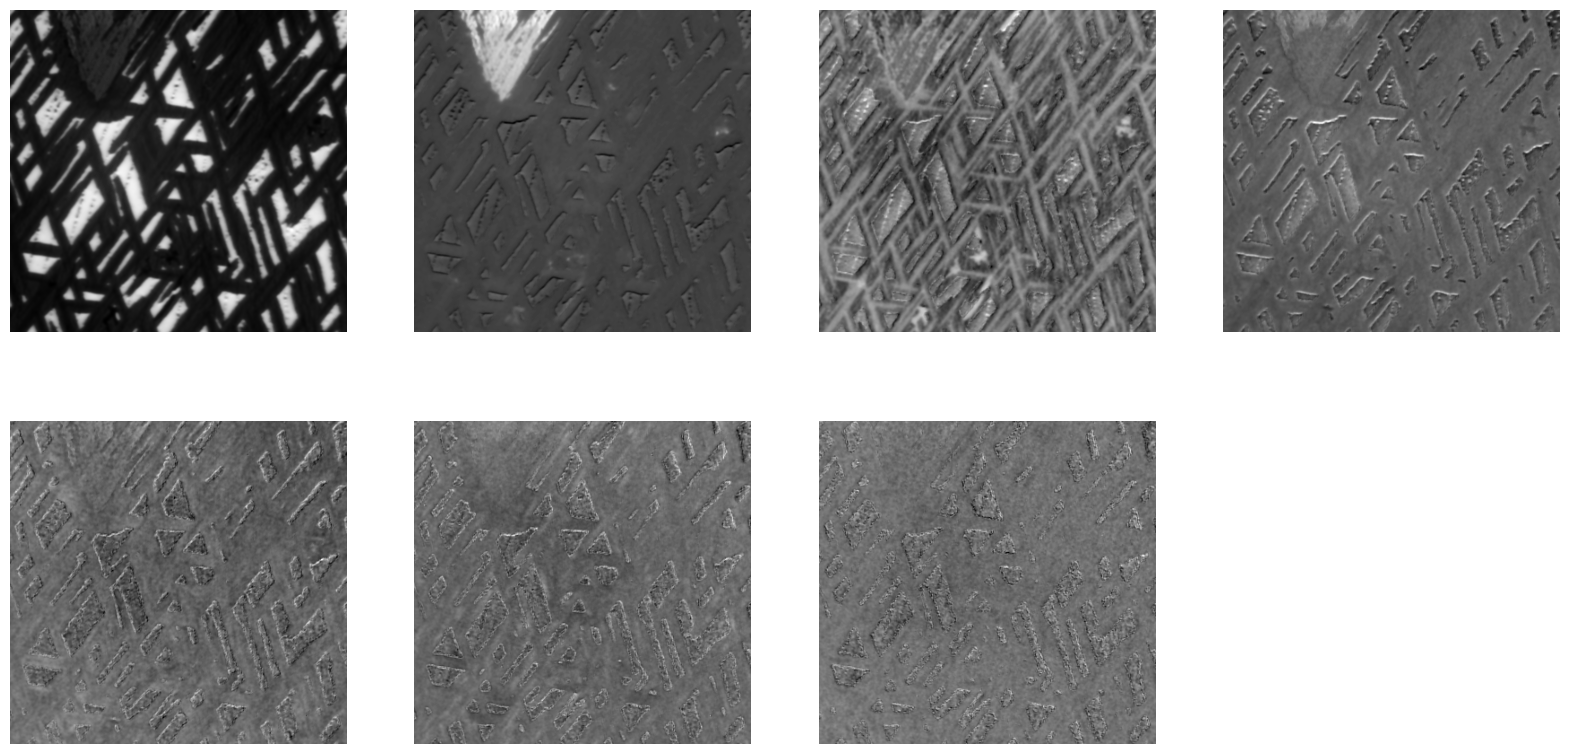

In [5]:
X, h, w = cluster.stack2vectors(stack, mask_outer=0.2) # cut away 20% on every side

if not load_model:
    if do_pendry:
        X = cluster.pendryfy(X, stack.energy)
    trafo, inv_trafo, model = cluster.component_analysis(X, "pca", n_components=n_components)
    W = trafo(X)
    
    comps = cluster.vectors2stack(W, h, w)
    leem.plot_mov(comps, fields=None)

## Clustering

Now follows the actual cluster analysis, which is simple to do. The `cluster_analysis()` function takes different keyword arguments depending on the algorithm and always returns `labels` and a model (can be saved by `save_model(model, filename)` and loaded by `labels, model = load_cluster_model(filename)`).

`labels` has the same format as `X`, but only one image that contains integers (the "cluster number"). `labels` will be ordered in cluster size, so the smallest cluster has label `0` and the next one `1` and so on.

In [6]:
if load_model:
    labels, model = cluster.load_cluster_model(f"data/{fname}.model")
if do_ca:
    labels, model = cluster.cluster_analysis(W, "pc-kmeans", n_clusters=n_clusters, metric="euclidean_square")
    cluster.save_model(model, f"data/{fname}.model")

Started cluster analysis
PC-KMEANS: Found 7 clusters
Finished cluster analysis in 0:00:03


## Visualization

To plot the results, the initial stack and its h and w value are needed to extract the correct IV curves. The labels need to be reshaped correctly. Some examples on how to look at the data follow.

Maybe we want to look at each cluster separately:

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


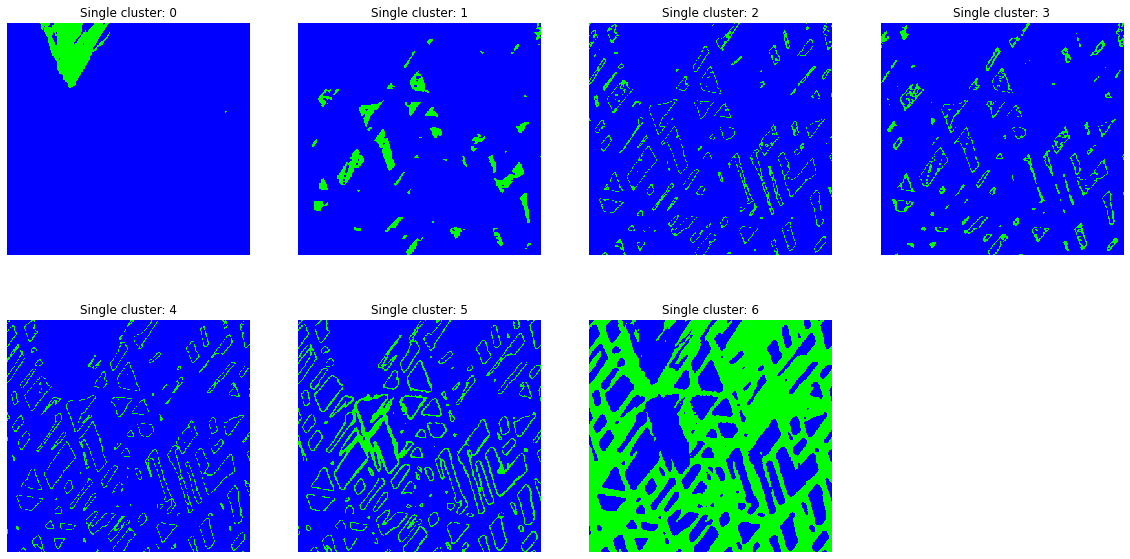

In [13]:
cluster.plot_single_clusters(labels.reshape(h, w))

To just plot the full map and its IV curves and save it to a file use `cluster.plot_clustermap()` and `cluster.plot_IVs` without any `cmap` or `legend` argument like documented below. This guide will however go into more detail.

We can see that some of the clusters are really the same phase. For a better fit, you can tweak the number of PCA components or clusters---or you can just combine two clusters. For that, use `cluster.combine_labels()`. It takes the original labels as argument, and a list of "combo-lists", i.e. a list of lists of clusters that belong together. It prints the amounts of pixel that each phase has.

In [14]:
combined_labels = cluster.combine_labels(labels, [(1, 2, 4), (5, 6)])

Combined cluster 0: 5580 pixels (4.122340425531915 %)
Combined cluster 1: 23042 pixels (17.02275413711584 %)
Combined cluster 3: 7494 pixels (5.536347517730497 %)
Combined cluster 5: 99244 pixels (73.31855791962175 %)


To use consistent colors and labels for our phases, we define a dictionary `cl_colors`. Remember that the keys might have to be updated for each repeated clustering run. Then use it for `cluster.make_cmap()` to get a colormap and a legend.

**Wrongly assigned cluster numbers will appear as wrong colors later**

In [15]:
phases = {
    0: ("RuO$_2$(101)", "#0000FF"),
    1: ("substrate", "#F0E442"),
    3: ("RuO$_2$(100)", "#D55E00"),
    5: ("RuO$_2$(110)", "#000"),
}
cmap, legend = cluster.make_cmap(phases, combined_labels)

Now use all this with `cluster.plot_clustermap()` and `cluster.plot_IVs()`. For better overview, we use the `ax` arguments and a 3-part figure to plot the next things next to each other. The arguments should be self explanatory.

<AxesSubplot:xlabel='Energy in eV', ylabel='Intensity in a.u.'>

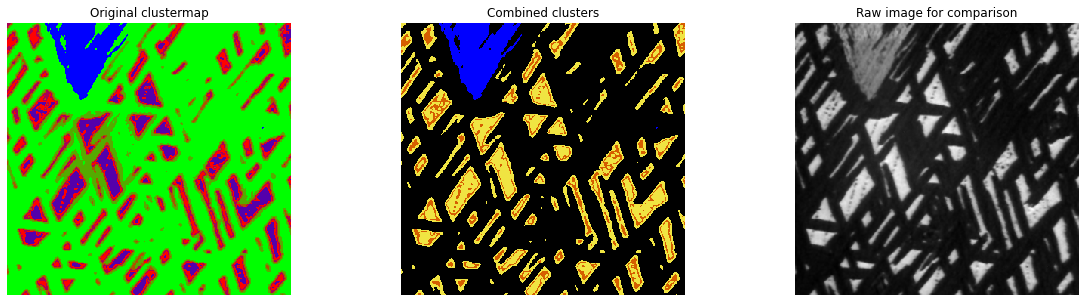

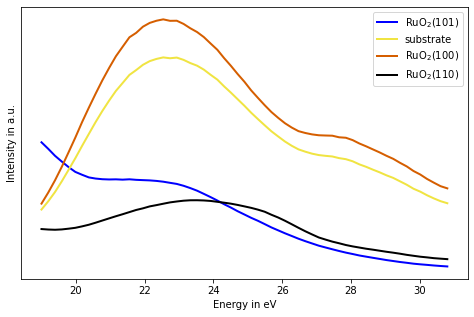

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].set_title("Original clustermap")
cluster.plot_clustermap(labels.reshape(h, w), ofile=f"img/{fname}_CA.png", ax=axes[0], cmap="brg")

axes[1].set_title("Combined clusters")
cluster.plot_clustermap(combined_labels.reshape(h, w), ofile=f"img/{fname}_CA2.png", ax=axes[1], cmap=cmap)

axes[2].set_title("Raw image for comparison")
img = cluster.plot_raw(stack[5], ofile=f"img/{fname}_RS.png", mask_outer=0.2, ax=axes[2])

cluster.plot_IVs(stack, combined_labels, ofile=f"img/{fname}_curves.png", mask_outer=0.2, legend=legend, cmap=cmap)